In [1]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [2]:
# remotes::install_github("glmmTMB/glmmTMB", subdir = "glmmTMB")


# Load Data

In [3]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2016_2023.csv" # nolint
# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2016_2024.csv" # nolint
# local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR_2018_2024.csv" # nolint
local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR.csv"
base_df <- read.csv(local_input_path)

print(base_df)


           date                        regiao mental_health_visits total_atd
1    2018-01-01                           sul                86601   3323595
2    2018-02-01                           sul                83997   3127761
3    2018-03-01                           sul                95073   3799601
4    2018-04-01                           sul                99755   3954977
5    2018-05-01                           sul                96343   3950949
6    2018-06-01                           sul                90526   3629643
7    2018-07-01                           sul                96069   3895748
8    2018-08-01                           sul               104619   4238054
9    2018-09-01                           sul                92901   3627309
10   2018-10-01                           sul               111666   4475717
11   2018-11-01                           sul                94086   3724671
12   2018-12-01                           sul                70911   2857177

# Imports

In [4]:
# install.packages(c(
#    "lme4",
#     "performance",
#      "DHARMa",
#      "ggplot2",
#      "ggeffects",
#      "purrr",
#      "emmeans",
#      "performance",
#      "dplyr",
#      "patchwork",
#      "see",
#      "broom.mixed",
#      "dotwhisker",
#      "tidyr",
#      "stringr",
#      "glarma",
#      "brms",
#      "remotes",
#      "tibble"))

# install.packages(c("lubridate"))
# install.packages(c(
#    # "lubridate",
#    # "ggplot2",
#    # "purrr",
#    #"glmmTMB"
# ))
library(gamlss.add)
library(gamlss)
library(glarma)
library(dplyr)
library(MASS)
library(nlme)
library(purrr)
library(brms)
library(cmdstanr)
library(writexl)
library(glmmTMB) # For NB GLMM with autocorrelation

library(lubridate)
# library(lme4) # Alternative for basic GLMM
# library(performance) # For model checks
# library(DHARMa) # For residual diagnostics
# library(ggplot2) # For plots
# library(ggeffects)
# library(purrr)
# library(emmeans)
# library(performance)

# library(patchwork)
# library(see)
# library(broom.mixed)
# library(dotwhisker)
# library(tidyr)
# library(stringr)
# library(glarma)
# library(brms)
# library(remotes)
# library(tibble)


Carregando pacotes exigidos: gamlss.dist

Carregando pacotes exigidos: gamlss

Carregando pacotes exigidos: splines

Carregando pacotes exigidos: gamlss.data


Anexando pacote: 'gamlss.data'


O seguinte objeto é mascarado por 'package:datasets':

    sleep


Carregando pacotes exigidos: nlme

Carregando pacotes exigidos: parallel

 **********   GAMLSS Version 5.4-22  ********** 

For more on GAMLSS look at https://www.gamlss.com/

Type gamlssNews() to see new features/changes/bug fixes.


Carregando pacotes exigidos: mgcv

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


Anexando pacote: 'mgcv'


O seguinte objeto é mascarado por 'package:gamlss':

    lp


Carregando pacotes exigidos: nnet


Anexando pacote: 'nnet'


O seguinte objeto é mascarado por 'package:mgcv':

    multinom


Carregando pacotes exigidos: rpart


Anexando pacote: 'dplyr'


O seguinte objeto é mascarado por 'package:nlme':

    collapse


Os seguintes objetos são mascarados por 'package:stats':

  

In [25]:
options(repr.plot.width = 12, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown


# Model Defs

In [6]:
#' Fit GLMM with PQL estimation and AR(1) structure
#'
#' @param data Dataframe containing all variables
#' @param response_var Name of response variable (count data)
#' @param fixed_effects Vector of fixed effect variable names
#' @param offset_var Name of offset variable (should be log-transformed)
#' @param time_var Name of time variable for AR(1) structure
#' @param group_var Name of grouping variable (default intercept-only)
#' @param theta Starting value for negative binomial theta (NULL for estimation)
#'
#' @return Fitted model object
#' @export
#'
#' @examples
#' model <- fit_glmm_ar1(
#'   data = my_data,
#'   response_var = "mental_health_visits",
#'   fixed_effects = c("periodo", "Pandemia_Step", "Pandemia_Trend"),
#'   offset_var = "log_total_visits",
#'   time_var = "month"
#' )
fit_glmm_ar1 <- function(data,
                         response_var,
                         fixed_effects,
                         offset_var = NULL,
                         time_var,
                         group_var = NULL,
                         theta = 1) {
  # Load required packages
  require(nlme)
  require(MASS)

  # Create formula components
  fixed_part <- paste(
    response_var, "~",
    paste(fixed_effects, collapse = " + ")
  )

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Handle grouping structure
  if (is.null(group_var)) {
    data$..group.. <- factor(1) # Intercept-only random effect
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Fit model
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta), # quasipoisson(),#poisson(),#
    correlation = corAR1(form = cor_formula),
    data = data,
    verbose = FALSE
  )


  # Add model components to object for easier reference
  model$call$fixed <- fixed_part
  model$call$random <- random_formula
  model$call$correlation <- cor_formula

  return(model)
}


In [7]:
fit_glmm_arma <- function(data,
                          response_var,
                          fixed_effects,
                          offset_var = NULL,
                          time_var,
                          group_var = NULL,
                          theta = 1,
                          ar_order = 1, # Ordem AR(p)
                          ma_order = 0) { # Ordem MA(q)

  require(nlme)
  require(MASS)
  require(dplyr)

  # Criar fórmula fixa
  fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Estrutura aleatória
  if (is.null(group_var)) {
    data$..group.. <- factor(1)
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Estrutura de correlação ARMA
  if (ar_order > 0 | ma_order > 0) {
    cor_struct <- corARMA(form = cor_formula, p = ar_order, q = ma_order)
  } else {
    cor_struct <- NULL
  }

  # Ajustar modelo
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta),
    correlation = cor_struct,
    data = data,
    verbose = FALSE
  )

  return(model)
}


In [8]:
library(nlme)
library(MASS)
library(dplyr)

# 1) Função auxiliar para estimar α e θ por momentos a partir de um ajuste Poisson
estimate_theta_moments <- function(df, response_var, fixed_effects, offset_var = NULL) {
  # montar fórmula
  rhs <- paste(fixed_effects, collapse = " + ")
  if (!is.null(offset_var)) rhs <- paste0(rhs, " + offset(", offset_var, ")")
  form <- as.formula(paste(response_var, "~", rhs))

  # ajusta Poisson
  pois <- glm(form, data = df, family = poisson())

  # extrai y e mu
  y <- df[[response_var]]
  mu <- fitted(pois)

  # estimador de momentos para α: sum[(y - mu)^2 - mu] / sum(mu^2)
  num <- sum((y - mu)^2 - mu)
  den <- sum(mu^2)
  alpha_hat <- max(num / den, 0)

  # θ = 1/α (MASS::negative.binomial() usa var = μ + μ^2/θ)
  theta_hat <- if (alpha_hat > 0) 1 / alpha_hat else Inf

  # opcional: índice de dispersão Pearson φ
  pearson_chi2 <- sum((y - mu)^2 / mu)
  phi_hat <- pearson_chi2 / pois$df.residual

  list(alpha = alpha_hat, phi = phi_hat, theta = theta_hat)
}

# 2) Função principal, agora estimando θ se não for fornecido
fit_glmm_arma_2moment <- function(data,
                                  response_var,
                                  fixed_effects,
                                  offset_var = NULL,
                                  time_var,
                                  group_var = NULL,
                                  theta = NULL,
                                  ar_order = 1,
                                  ma_order = 0) {
  # estima θ via momentos se theta=NULL
  if (is.null(theta)) {
    est <- estimate_theta_moments(data, response_var, fixed_effects, offset_var)
    theta <- est$theta
    message(sprintf(
      "Estimativa de theta por momentos: %.3f (α = %.4f, φ = %.3f)",
      theta, est$alpha, est$phi
    ))
  }

  # construir parte fixa da fórmula
  fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))
  if (!is.null(offset_var)) {
    fixed_part <- paste0(fixed_part, " + offset(", offset_var, ")")
  }

  # estrutura de efeitos aleatórios e correlação
  if (is.null(group_var)) {
    data$..group.. <- factor(1)
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # correlação ARMA
  cor_struct <- if (ar_order > 0 || ma_order > 0) {
    corARMA(form = cor_formula, p = ar_order, q = ma_order)
  } else {
    NULL
  }

  # ajuste final
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta),
    correlation = cor_struct,
    data = data,
    verbose = FALSE
  )

  return(model)
}


In [9]:
fit_glmmTMB_auto_by_region <- function(data,
                                       response_var,
                                       fixed_effects,
                                       offset_var = NULL,
                                       time_var,
                                       region_var,
                                       group_var = NULL,
                                       random_slope = TRUE) {
  # pacotes necessários
  if (!requireNamespace("glmmTMB", quietly = TRUE)) {
    stop("Instale o pacote 'glmmTMB' para usar esta função.")
  }
  if (!requireNamespace("dplyr", quietly = TRUE)) {
    stop("Instale o pacote 'dplyr' para usar esta função.")
  }

  # identificar níveis de região
  regions <- unique(data[[region_var]])
  models <- vector("list", length(regions))
  names(models) <- regions

  for (reg in regions) {
    # subconjunto por região
    df_reg <- dplyr::filter(data, .data[[region_var]] == reg)

    # construir parte fixa
    fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))
    if (!is.null(offset_var)) {
      fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
    }

    # construir efeitos aleatórios (intercepto e opcionalmente slope em time)
    random_part <- ""
    if (!is.null(group_var)) {
      random_part <- if (random_slope) {
        paste0(" + (1 + ", time_var, " | ", group_var, ")")
      } else {
        paste0(" + (1 | ", group_var, ")")
      }
    }

    # fórmula final
    form <- as.formula(paste0(fixed_part, random_part))

    # ajuste automático de θ (glmmTMB estima θ por ML)
    model <- glmmTMB::glmmTMB(
      formula = form,
      data = df_reg,
      family = glmmTMB::nbinom2(link = "log"),
      dispformula = ~1
    )

    # exibir sumário imediato do modelo
    cat("\n===== Sumário para região:", reg, " =====\n")
    print(summary(model))

    # armazenar o modelo
    models[[as.character(reg)]] <- model
  }

  return(models)
}


# Model Run

In [10]:
# Inicialize uma lista para guardar os modelos
models_list <- list()

start_y <- 2016
end_y <- 2023

base_df <- base_df %>% mutate(date = as.Date(date))
regression_df <- base_df %>%
  filter(between((year(date)), start_y, end_y))

fixed_effects <- c(
  "periodo",
  "Pandemia_Step",
  "Pandemia_Trend",
  "PosPandemia_Step",
  "PosPandemia_Trend"
  # , "I(periodo^2)"

  # , "cos1_12", "sin1_12"
  # , "cos1_6", "sin1_6" # , "cos1", "sin1"
)


# Loop para ajustar os modelos por região e armazenar na lista
for (reg in unique(regression_df$regiao)) {
  require(dplyr)
  cat("=============================================Rodando:", reg, "\n")
  reg_data <- regression_df %>% filter(regiao == reg)

  model <- fit_glmm_arma(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = fixed_effects,
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )


  # Armazenar o modelo na lista com a chave sendo a região
  models_list[[reg]] <- model
  # print('-----R² condicional/marginal')
  # print(performance::r2(model))  # R² condicional/marginal
  # Imprimir o resumo do modelo para verificação
  print(summary(model))
}


=============================================Rodando: sul 
Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
        (Intercept)   Residual
StdDev: 1.03246e-06 0.05704642

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
      Phi1     Theta1 
-0.1510561  0.6300442 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                      Value  Std.Error DF   t-value p-value
(Intercept)        3.196405 0.02923654 66 109.32912  0.0000
periodo            0.004860 0.00180179 66   2.69731  0.0089
Pandemia_Step      0.152310 0.03931648 66   3.87394  0.0002
Pandemia_Trend    -0.015885 0.00285137 66  -5.57116  0.0000
PosPandemia_Step  -0.211150 0.07551098 66  -2.79628  0.0068
PosPandemia_Trend  0.007379 0.00315

In [11]:
# Inicialize uma lista para guardar os modelos
models_list <- list()

# Loop para ajustar os modelos por região e armazenar na lista
for (reg in unique(regression_df$regiao)) {
  require(dplyr)
  cat("=============================================Rodando:", reg, "\n")
  reg_data <- regression_df %>% filter(regiao == reg)

  model <- fit_glmm_arma(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = c(
      "periodo", "Pandemia_Step", "Pandemia_Trend",
      "PosPandemia_Step", "PosPandemia_Trend"
      # , "cos1_12", "sin1_12"
      # , "cos1_6", "sin1_6" # , "cos1", "sin1"
    ),
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )


  model <- fit_glmm_arma_2moment(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = c(
      "periodo", "Pandemia_Step", "Pandemia_Trend",
      "PosPandemia_Step", "PosPandemia_Trend"
      # , "cos1_12", "sin1_12"
      # , "cos1_6", "sin1_6" # , "cos1", "sin1"
    ),
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )



  # Armazenar o modelo na lista com a chave sendo a região
  models_list[[reg]] <- model
  # print('-----R² condicional/marginal')
  # print(performance::r2(model))  # R² condicional/marginal
  # Imprimir o resumo do modelo para verificação
  print(summary(model))
}


=============================================Rodando: sul 


Estimativa de theta por momentos: 312.207 (α = 0.0032, φ = 462.140)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 8.474023e-07 1.006698

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
      Phi1     Theta1 
-0.1510955  0.6300499 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                      Value  Std.Error DF   t-value p-value
(Intercept)        3.196388 0.02924881 66 109.28267  0.0000
periodo            0.004861 0.00180247 66   2.69680  0.0089
Pandemia_Step      0.152259 0.03933104 66   3.87123  0.0003
Pandemia_Trend    -0.015884 0.00285211 66  -5.56924  0.0000
PosPandemia_Step  -0.211179 0.07552833 66  -2.79602  0.0068
PosPandemia_Trend  0.007378 0.00315878 66   2.33580  0.0225
 Correlation: 
                  (In

Estimativa de theta por momentos: 410.557 (α = 0.0024, φ = 695.162)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.007588e-06 1.050914

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.2416147 0.2003230 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF  t-value p-value
(Intercept)        2.8811995 0.02948011 66 97.73368  0.0000
periodo            0.0133021 0.00180920 66  7.35248  0.0000
Pandemia_Step      0.1604227 0.03887088 66  4.12707  0.0001
Pandemia_Trend    -0.0171656 0.00288934 66 -5.94099  0.0000
PosPandemia_Step  -0.2609443 0.07590568 66 -3.43774  0.0010
PosPandemia_Trend -0.0027795 0.00315400 66 -0.88127  0.3814
 Correlation: 
                  (Intr) 

Estimativa de theta por momentos: 212.035 (α = 0.0047, φ = 127.248)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.375312e-06 1.220981

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3313112 0.5649110 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF  t-value p-value
(Intercept)        2.2230357 0.05404398 66 41.13382  0.0000
periodo            0.0085187 0.00318525 66  2.67441  0.0094
Pandemia_Step      0.1624399 0.05762958 66  2.81869  0.0064
Pandemia_Trend    -0.0063743 0.00526718 66 -1.21020  0.2305
PosPandemia_Step   0.0649460 0.13341451 66  0.48680  0.6280
PosPandemia_Trend  0.0081735 0.00539807 66  1.51416  0.1348
 Correlation: 
                  (Intr) 

Estimativa de theta por momentos: 322.783 (α = 0.0031, φ = 438.699)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.187617e-06  1.17448

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3549376 0.2875941 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF  t-value p-value
(Intercept)        2.2620662 0.04124649 66 54.84264  0.0000
periodo            0.0158096 0.00248748 66  6.35569  0.0000
Pandemia_Step      0.3053986 0.04990434 66  6.11968  0.0000
Pandemia_Trend    -0.0127908 0.00404520 66 -3.16198  0.0024
PosPandemia_Step  -0.0030299 0.10431436 66 -0.02905  0.9769
PosPandemia_Trend  0.0032993 0.00428080 66  0.77073  0.4436
 Correlation: 
                  (Intr) 

Estimativa de theta por momentos: 172.101 (α = 0.0058, φ = 267.356)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept)  Residual
StdDev: 1.091928e-06 0.9735695

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.1043134 0.5199706 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF  t-value p-value
(Intercept)        2.9988235 0.04211826 66 71.20007  0.0000
periodo            0.0078159 0.00256550 66  3.04653  0.0033
Pandemia_Step      0.1133697 0.05362805 66  2.11400  0.0383
Pandemia_Trend    -0.0118820 0.00411182 66 -2.88972  0.0052
PosPandemia_Step  -0.1361714 0.10738340 66 -1.26809  0.2092
PosPandemia_Trend  0.0010409 0.00445750 66  0.23351  0.8161
 Correlation: 
                  (Intr

Estimativa de theta por momentos: 168.620 (α = 0.0059, φ = 86.194)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 2.207833e-06 1.153213

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
      Phi1     Theta1 
 0.7378010 -0.1889013 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF    t-value p-value
(Intercept)       -1.3309109 0.07196702 66 -18.493344  0.0000
periodo            0.0235605 0.00416992 66   5.650110  0.0000
Pandemia_Step      0.4477939 0.07012537 66   6.385619  0.0000
Pandemia_Trend    -0.0441531 0.00709959 66  -6.219110  0.0000
PosPandemia_Step  -0.6370406 0.17716538 66  -3.595740  0.0006
PosPandemia_Trend -0.0116741 0.00689608 66  -1.692867  0.0952
 Correlation: 
       

Estimativa de theta por momentos: 171.802 (α = 0.0058, φ = 160.933)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.191451e-06 1.011429

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.1395907 0.4035070 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                        Value  Std.Error DF   t-value p-value
(Intercept)       -0.07605422 0.04377413 66 -1.737424  0.0870
periodo            0.00183219 0.00267927 66  0.683839  0.4965
Pandemia_Step     -0.17763253 0.05705963 66 -3.113103  0.0027
Pandemia_Trend     0.00751793 0.00428418 66  1.754813  0.0839
PosPandemia_Step   0.02689315 0.11225460 66  0.239573  0.8114
PosPandemia_Trend  0.02065628 0.00466223 66  4.430556  0.0000
 Correlation: 
           

Estimativa de theta por momentos: 138.154 (α = 0.0072, φ = 366.628)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.578567e-06 1.472242

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3793925 0.4217684 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF   t-value p-value
(Intercept)       -0.2002572 0.08195049 66 -2.443637  0.0172
periodo            0.0164368 0.00486762 66  3.376766  0.0012
Pandemia_Step     -0.7744159 0.09158981 66 -8.455262  0.0000
Pandemia_Trend     0.0281388 0.00803016 66  3.504145  0.0008
PosPandemia_Step  -0.1472007 0.20414798 66 -0.721049  0.4734
PosPandemia_Trend  0.0047990 0.00829286 66  0.578695  0.5648
 Correlation: 
                  

Estimativa de theta por momentos: 260.298 (α = 0.0038, φ = 51.287)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.056519e-06 1.078482

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
       Phi1      Theta1 
-0.03707494  0.36017055 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF    t-value p-value
(Intercept)       -0.9620789 0.03431691 66 -28.035124  0.0000
periodo            0.0075411 0.00212521 66   3.548410  0.0007
Pandemia_Step     -0.2257406 0.04736786 66  -4.765691  0.0000
Pandemia_Trend     0.0062702 0.00334960 66   1.871931  0.0656
PosPandemia_Step  -0.1574796 0.08905489 66  -1.768343  0.0816
PosPandemia_Trend  0.0056218 0.00371426 66   1.513581  0.1349
 Correlation: 
   

Estimativa de theta por momentos: 325.390 (α = 0.0031, φ = 17.272)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.114964e-06 1.056271

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3712318 0.0305543 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF   t-value p-value
(Intercept)       -2.2033154 0.03667704 66 -60.07343  0.0000
periodo            0.0216891 0.00222877 66   9.73141  0.0000
Pandemia_Step      0.0486465 0.04703934 66   1.03417  0.3048
Pandemia_Trend    -0.0176987 0.00353978 66  -4.99993  0.0000
PosPandemia_Step  -0.4839746 0.09273543 66  -5.21887  0.0000
PosPandemia_Trend -0.0083789 0.00378877 66  -2.21152  0.0305
 Correlation: 
                  

Estimativa de theta por momentos: 382.825 (α = 0.0026, φ = 48.919)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept)  Residual
StdDev: 1.093373e-06 0.9872184

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.1368517 0.3545683 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF    t-value p-value
(Intercept)       -0.5183272 0.02856187 66 -18.147525  0.0000
periodo            0.0109840 0.00175167 66   6.270576  0.0000
Pandemia_Step      0.3819720 0.03757691 66  10.165071  0.0000
Pandemia_Trend    -0.0325167 0.00278668 66 -11.668593  0.0000
PosPandemia_Step  -0.3817094 0.07334865 66  -5.204042  0.0000
PosPandemia_Trend -0.0081906 0.00304652 66  -2.688520  0.0091
 Correlation: 
         

Estimativa de theta por momentos: 354.708 (α = 0.0028, φ = 810.500)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 9.422058e-07 1.043445

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.1805055 0.3549809 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF  t-value p-value
(Intercept)        1.7721834 0.03170843 66 55.88998  0.0000
periodo            0.0145682 0.00193949 66  7.51135  0.0000
Pandemia_Step      0.2750140 0.04115453 66  6.68247  0.0000
Pandemia_Trend    -0.0145968 0.00310350 66 -4.70334  0.0000
PosPandemia_Step  -0.0694861 0.08129718 66 -0.85472  0.3958
PosPandemia_Trend  0.0008813 0.00337617 66  0.26103  0.7949
 Correlation: 
                  (Intr) 

Estimativa de theta por momentos: 351.904 (α = 0.0028, φ = 433.619)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.027716e-06 1.076775

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.2218020 0.2301709 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF  t-value p-value
(Intercept)        1.6154946 0.03253302 66 49.65708  0.0000
periodo            0.0082008 0.00199673 66  4.10710  0.0001
Pandemia_Step      0.1971077 0.04291203 66  4.59330  0.0000
Pandemia_Trend    -0.0219806 0.00318782 66 -6.89518  0.0000
PosPandemia_Step  -0.3277623 0.08376582 66 -3.91284  0.0002
PosPandemia_Trend -0.0039132 0.00348199 66 -1.12383  0.2652
 Correlation: 
                  (Intr) 

Estimativa de theta por momentos: 368.206 (α = 0.0027, φ = 115.324)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.133894e-06 1.143573

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.3862262 0.2698798 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                        Value  Std.Error DF   t-value p-value
(Intercept)        0.25924333 0.03846347 66  6.739988  0.0000
periodo            0.00660336 0.00231281 66  2.855122  0.0057
Pandemia_Step      0.16306065 0.04586681 66  3.555091  0.0007
Pandemia_Trend    -0.01696298 0.00377483 66 -4.493704  0.0000
PosPandemia_Step  -0.25787992 0.09701469 66 -2.658153  0.0098
PosPandemia_Trend  0.00402499 0.00396843 66  1.014253  0.3142
 Correlation: 
           

Estimativa de theta por momentos: 321.177 (α = 0.0031, φ = 43.177)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 1.019218e-06 1.025765

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
      Phi1     Theta1 
-0.2465448  0.6268331 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF   t-value p-value
(Intercept)       -0.9843052 0.02881312 66 -34.16170  0.0000
periodo            0.0092145 0.00178250 66   5.16945  0.0000
Pandemia_Step      0.2111453 0.03947338 66   5.34905  0.0000
Pandemia_Trend    -0.0171658 0.00279937 66  -6.13201  0.0000
PosPandemia_Step  -0.1502338 0.07459410 66  -2.01402  0.0481
PosPandemia_Trend  0.0075566 0.00311036 66   2.42951  0.0178
 Correlation: 
              

Estimativa de theta por momentos: 379.853 (α = 0.0026, φ = 73.831)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 9.035015e-07 1.021463

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
      Phi1     Theta1 
-0.1584876  0.5623871 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                        Value  Std.Error DF   t-value p-value
(Intercept)       -0.18790024 0.02674237 66 -7.026313   0.000
periodo            0.00844126 0.00165314 66  5.106207   0.000
Pandemia_Step      0.19103212 0.03649429 66  5.234575   0.000
Pandemia_Trend    -0.01470251 0.00260453 66 -5.644979   0.000
PosPandemia_Step  -0.12994603 0.06925664 66 -1.876297   0.065
PosPandemia_Trend -0.00207404 0.00289298 66 -0.716924   0.476
 Correlation: 
       

Estimativa de theta por momentos: 421.055 (α = 0.0024, φ = 1504.888)



Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept) Residual
StdDev: 8.761055e-07 1.042865

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
     Phi1    Theta1 
0.1112418 0.3419608 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + offset(offset) 
                       Value  Std.Error DF   t-value p-value
(Intercept)        2.8027547 0.02779559 66 100.83453  0.0000
periodo            0.0111360 0.00171033 66   6.51101  0.0000
Pandemia_Step      0.1769397 0.03709777 66   4.76955  0.0000
Pandemia_Trend    -0.0147569 0.00271950 66  -5.42632  0.0000
PosPandemia_Step  -0.1705132 0.07173610 66  -2.37695  0.0204
PosPandemia_Trend  0.0018975 0.00299038 66   0.63454  0.5279
 Correlation: 
                  

# Diagnóstico

In [12]:
# GLMM TMB
if (!dir.exists("acf_plots")) dir.create("acf_plots")
if (!dir.exists("model_tests")) dir.create("model_tests")

sink(file = "model_tests/ljung_box_results.txt")

for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Resíduos de Pearson
  res <- residuals(model, type = "pearson")

  # Plot ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  acf(res, main = paste("ACF -", reg), lag.max = 36, ylim = c(-0.5, 1))
  pacf(res, main = paste("PACF -", reg), lag.max = 36, ylim = c(-0.5, 1))

  dev.off()

  # Teste Ljung-Box
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos de Pearson:\n\n")

  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  cat("Gráficos e testes gerados para:", reg, "\n")
}

sink()


In [13]:
# Criar pastas para salvar os resultados
if (!dir.exists("acf_plots")) {
  dir.create("acf_plots")
}
if (!dir.exists("model_tests")) {
  dir.create("model_tests")
}

# Arquivo para salvar os testes Ljung-Box
sink(file = "model_tests/ljung_box_results.txt")

# Loop através de cada modelo na lista
for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Extrair resíduos normalizados
  res <- residuals(model, type = "normalized")

  # Gráficos ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  # Plot ACF
  acf(res,
    main = paste("ACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  # Plot PACF
  pacf(res,
    main = paste("PACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  dev.off()

  # Teste Ljung-Box para diferentes lags
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos:\n\n")

  # Testar para lags específicos (1, 9, 12, 24, 25)
  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))

    # Adicionar asterisco para significância
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  # Mostrar mensagem de progresso
  cat("Gráficos e testes gerados para:", reg, "\n")
}

# Fechar o arquivo de saída
sink()


# Extrair

In [14]:
extrair_tabela_formatada <- function(models_list,
                                     coef_map = NULL,
                                     round_digits = 3) {
  if (is.null(coef_map)) {
    coef_map <- list(
      "Pandemia_Step" = c("Pandemia", "Mudança de nível"),
      "Pandemia_Trend" = c("Pandemia", "Mudança de tendência"),
      "PosPandemia_Step" = c("Pós-pandemia", "Mudança de nível"),
      "PosPandemia_Trend" = c("Pós-pandemia", "Mudança de tendência")
    )
  }

  linhas <- list()

  for (regiao in names(models_list)) {
    model <- models_list[[regiao]]
    coefs <- summary(model)$tTable

    for (coef in names(coef_map)) {
      if (coef %in% rownames(coefs)) {
        beta <- coefs[coef, "Value"]
        se <- coefs[coef, "Std.Error"]
        pval <- coefs[coef, "p-value"]

        irr <- exp(beta)
        ci_low <- exp(beta - 1.96 * se)
        ci_high <- exp(beta + 1.96 * se)

        p_str <- ifelse(pval < 0.001, "< 0.001", round(pval, 4))

        linha <- data.frame(
          Regiao = regiao,
          Efeito = coef_map[[coef]][2],
          Periodo = coef_map[[coef]][1],
          IRR = round(irr, round_digits),
          IC95 = sprintf("%.*f – %.*f", round_digits, ci_low, round_digits, ci_high),
          p_valor = p_str,
          stringsAsFactors = FALSE
        )
      } else {
        linha <- data.frame(
          Regiao = regiao,
          Efeito = coef_map[[coef]][2],
          Periodo = coef_map[[coef]][1],
          IRR = "",
          IC95 = "",
          p_valor = "",
          stringsAsFactors = FALSE
        )
      }

      linhas[[length(linhas) + 1]] <- linha
    }
  }

  df <- do.call(rbind, linhas)

  # Pivotar para formato mais legível com colunas por período
  library(tidyr)
  df_pivot <- df %>%
    pivot_wider(
      names_from = Periodo,
      values_from = c(IRR, IC95, p_valor),
      names_sep = "_"
    )

  return(df_pivot)
}


In [ ]:
extrair_tabela_formatada_wide <- function(models_list,
                                          coef_map = NULL,
                                          round_digits = 5) {
  if (is.null(coef_map)) {
    coef_map <- list(
      "periodo" = c("Pré-pandemia", "Tendência"),
      "Pandemia_Step" = c("Pandemia", "Mudança de nível"),
      "Pandemia_Trend" = c("Pandemia", "Mudança de tendência"),
      "PosPandemia_Step" = c("Pós-pandemia", "Mudança de nível"),
      "PosPandemia_Trend" = c("Pós-pandemia", "Mudança de tendência")
    )
  }

  linhas <- list()

  for (regiao in names(models_list)) {
    model <- models_list[[regiao]]
    coefs <- summary(model)$tTable
    linha <- list(Regiao = regiao)

    for (coef in names(coef_map)) {
      if (coef %in% rownames(coefs)) {
        beta <- coefs[coef, "Value"]
        se <- coefs[coef, "Std.Error"]
        pval <- coefs[coef, "p-value"]

        irr <- exp(beta)
        ci_low <- exp(beta - 1.96 * se)
        ci_high <- exp(beta + 1.96 * se)

        p_str <- ifelse(pval < 0.001, "< 0.001", round(pval, 4))

        linha[[paste0("IRR_", coef)]] <- round(irr, round_digits)
        linha[[paste0("IC95_", coef)]] <- sprintf("%.*f – %.*f", round_digits, ci_low, round_digits, ci_high)
        linha[[paste0("p_", coef)]] <- p_str
      } else {
        linha[[paste0("IRR_", coef)]] <- ""
        linha[[paste0("IC95_", coef)]] <- ""
        linha[[paste0("p_", coef)]] <- ""
      }
    }

    linhas[[length(linhas) + 1]] <- as.data.frame(linha, stringsAsFactors = FALSE)
  }

  df_final <- do.call(rbind, linhas)
  return(df_final)
}


In [16]:
extrair_resultados_its_glmmpql <- function(models_list,
                                           coef_names = c("Intercept", "periodo", "Pandemia_Step", "Pandemia_Trend", "PosPandemia_Step", "PosPandemia_Trend"),
                                           add_exp = TRUE,
                                           round_digits = 6,
                                           formato = c("wide", "long")) {
  formato <- match.arg(formato)
  resultados <- list()

  for (regiao in names(models_list)) {
    modelo <- models_list[[regiao]]
    coefs <- summary(modelo)$tTable

    if (formato == "long") {
      for (coef in coef_names) {
        if (coef %in% rownames(coefs)) {
          beta <- coefs[coef, "Value"]
          se <- coefs[coef, "Std.Error"]
          pval <- coefs[coef, "p-value"]
          ci_low <- beta - 1.96 * se
          ci_high <- beta + 1.96 * se

          linha <- data.frame(
            Regiao_Grupo = regiao,
            Coeficiente = coef,
            beta = round(beta, round_digits),
            se = round(se, round_digits),
            p = round(pval, 4),
            CI95_inf = round(ci_low, round_digits),
            CI95_sup = round(ci_high, round_digits),
            stringsAsFactors = FALSE
          )

          if (add_exp) {
            linha$exp_beta <- round(exp(beta), round_digits)
            linha$exp_CI95_inf <- round(exp(ci_low), round_digits)
            linha$exp_CI95_sup <- round(exp(ci_high), round_digits)
          }

          resultados[[length(resultados) + 1]] <- linha
        }
      }
    } else if (formato == "wide") {
      linha <- list(Regiao_Grupo = regiao)
      for (coef in coef_names) {
        if (coef %in% rownames(coefs)) {
          beta <- coefs[coef, "Value"]
          se <- coefs[coef, "Std.Error"]
          pval <- coefs[coef, "p-value"]
          ci_low <- beta - 1.96 * se
          ci_high <- beta + 1.96 * se

          linha[[paste0(coef, "_coef")]] <- round(beta, round_digits)
          linha[[paste0(coef, "_se")]] <- round(se, round_digits)
          linha[[paste0(coef, "_p")]] <- round(pval, 4)
          linha[[paste0(coef, "_ci95_inf")]] <- round(ci_low, round_digits)
          linha[[paste0(coef, "_ci95_sup")]] <- round(ci_high, round_digits)

          if (add_exp) {
            linha[[paste0(coef, "_exp")]] <- round(exp(beta), round_digits)
            linha[[paste0(coef, "_exp_ci95_inf")]] <- round(exp(ci_low), round_digits)
            linha[[paste0(coef, "_exp_ci95_sup")]] <- round(exp(ci_high), round_digits)
          }
        }
      }
      resultados[[length(resultados) + 1]] <- as.data.frame(linha, stringsAsFactors = FALSE)
    }
  }

  df_resultados <- do.call(rbind, resultados)
  return(df_resultados)
}


In [ ]:
# tabela_resultados <- extrair_tabela_formatada(models_list)
tabela_resultados <- extrair_tabela_formatada_wide(models_list)
print(tabela_resultados)



coefs <- extrair_resultados_its_glmmpql(models_list, formato = "wide")

writexl::write_xlsx(coefs, "coefs_glmmpql.xlsx")
writexl::write_xlsx(tabela_resultados, "resultados_modelos_glmmpql.xlsx")


                          Regiao IRR_periodo      IC95_periodo p_periodo
1                            sul     1.00487 1.00133 – 1.00843    0.0089
2                        sudeste     1.01339 1.00980 – 1.01699   < 0.001
3                          norte     1.00856 1.00228 – 1.01487    0.0094
4                       nordeste     1.01594 1.01099 – 1.02090   < 0.001
5                   centro_oeste     1.00785 1.00279 – 1.01293    0.0033
6       F99_F99_nao_especificado     1.02384 1.01551 – 1.03224   < 0.001
7          F90_F98_comportamento     1.00183 0.99659 – 1.00711    0.4965
8        F80_F89_desenvolvimento     1.01657 1.00692 – 1.02632    0.0012
9              F70_F79_retardado     1.00757 1.00338 – 1.01178   < 0.001
10         F60_F69_personalidade     1.02193 1.01747 – 1.02640   < 0.001
11          F50_F59_fisiologicos     1.01104 1.00758 – 1.01452   < 0.001
12              F40_F48_ansiosos     1.01467 1.01082 – 1.01854   < 0.001
13                 F30_F39_humor     1.00823 1.0043

# Def plot panel

In [18]:
library(ggplot2)
library(dplyr)
library(purrr)

# Junta os dados com as previsões em um único data.frame
all_data <- map_dfr(names(models_list), function(reg) {
  model <- models_list[[reg]]
  reg_data <- regression_df %>% filter(regiao == reg)
  reg_data$fitted <- fitted(model)

  coefs <- model$coefficients$fixed

  intercept <- coefs["(Intercept)"]
  b_time <- coefs["periodo"]
  b_pstep <- coefs["Pandemia_Step"]
  b_ptrend <- coefs["Pandemia_Trend"]
  b_poststep <- coefs["PosPandemia_Step"]
  b_posttrend <- coefs["PosPandemia_Trend"]

  reg_data <- reg_data %>%
    mutate(
      regiao = reg, # garante que a coluna regiao esteja presente
      fase = case_when(
        PosPandemia_Step == 1 ~ "pos",
        Pandemia_Step == 1 ~ "pandemia",
        TRUE ~ "pre"
      ),
      predicted_segmented = case_when(
        fase == "pre" ~ exp(intercept + b_time * periodo),
        fase == "pandemia" ~ exp(intercept + b_pstep + b_time * periodo + b_ptrend * Pandemia_Trend),
        fase == "pos" ~ exp(intercept + b_poststep + b_time * periodo +
          b_posttrend * PosPandemia_Trend)
      ),
      predicted_counterfactual = exp(intercept + b_time * periodo)
    )

  return(reg_data)
})


In [19]:
# Define as regiões que vão para o primeiro painel
regioes_principais <- c("Brasil", "centro_oeste", "nordeste", "norte", "sudeste", "sul")
neuroticos <- c("F30_F39", "F40_F48")
brasil__ <- c("Brasil")

# Adiciona a variável 'painel'
panel_data <- all_data %>%
  mutate(
    painel = ifelse(regiao %in% regioes_principais,
      "Brasil e macrorregiões",
      "Agrupamentos de Transtornos Mentais"
    )
  )

neuroticos_data <- all_data %>%
  mutate(
    painel = ifelse(regiao %in% neuroticos,
      "Humor e Ansiedade",
      "outros"
    )
  )

brasil_data <- all_data %>%
  mutate(
    painel = ifelse(regiao %in% brasil__,
      "Brasil",
      "outros"
    )
  )


painel_1 <- panel_data %>% filter(painel == "Brasil e macrorregiões")
painel_neuroticos <- neuroticos_data %>% filter(painel == "Humor e Ansiedade")
painel_2 <- panel_data %>% filter(painel == "Agrupamentos de Transtornos Mentais")
painel_brasil <- brasil_data %>% filter(painel == "Brasil")


In [20]:
plot_its_painel <- function(data, titulo = "ITS por região", ncol = 3, scales = "free_y") {
  ggplot(data, aes(x = periodo)) +
    geom_point(aes(y = IR), size = 0.75, alpha = 0.6) +
    geom_line(aes(y = predicted_segmented), color = "#8c00ff") +
    geom_line(aes(y = predicted_counterfactual), linetype = "dashed") +
    facet_wrap(~regiao, scales = scales, ncol = ncol) +
    labs(
      title = titulo,
      x = "Período",
      y = "Taxa por 1000 atendimentos"
    ) +
    theme_minimal() +
    theme(
      strip.text = element_text(face = "bold"),
      axis.text.x = element_text(angle = 45, hjust = 1)
    )
}


In [ ]:
plot_its_painel <- function(data,
                            titulo = "ITS por região",
                            ncol = 3,
                            scales = "free_y",
                            pandemic_start = 28, # Mês (periodo) de início da pandemia
                            post_start = 52 # Mês de início do pós-pandemia
) {
  ggplot(data, aes(x = periodo)) +
    # Pontos observados
    geom_point(aes(y = IR), size = 0.75, alpha = 0.6) +

    # Linha segmentada (quebrada nos blocos pré/pandemia/pós)
    geom_line(aes(y = predicted_segmented, group = fase), color = "#8c00ff", size = 0.8) +

    # Contrafactual sempre contínuo
    geom_line(aes(y = predicted_counterfactual), linetype = "dashed") +

    # Sombreamento de fases
    annotate("rect",
      xmin = pandemic_start, xmax = post_start,
      ymin = -Inf, ymax = Inf,
      fill = "grey90", alpha = 0.3
    ) +
    annotate("rect",
      xmin = post_start, xmax = Inf,
      ymin = -Inf, ymax = Inf,
      fill = "grey80", alpha = 0.3
    ) +

    # Linhas verticais de corte
    geom_vline(xintercept = c(pandemic_start, post_start), linetype = "dotted") +
    facet_wrap(~regiao, scales = scales, ncol = ncol) +
    labs(
      title = titulo,
      x     = "Período (mês)",
      y     = "Taxa por 1000 atendimentos"
    ) +
    theme_minimal() +
    theme(
      strip.text        = element_text(face = "bold"),
      axis.text.x       = element_text(angle = 45, hjust = 1)
    )
}


# Plot

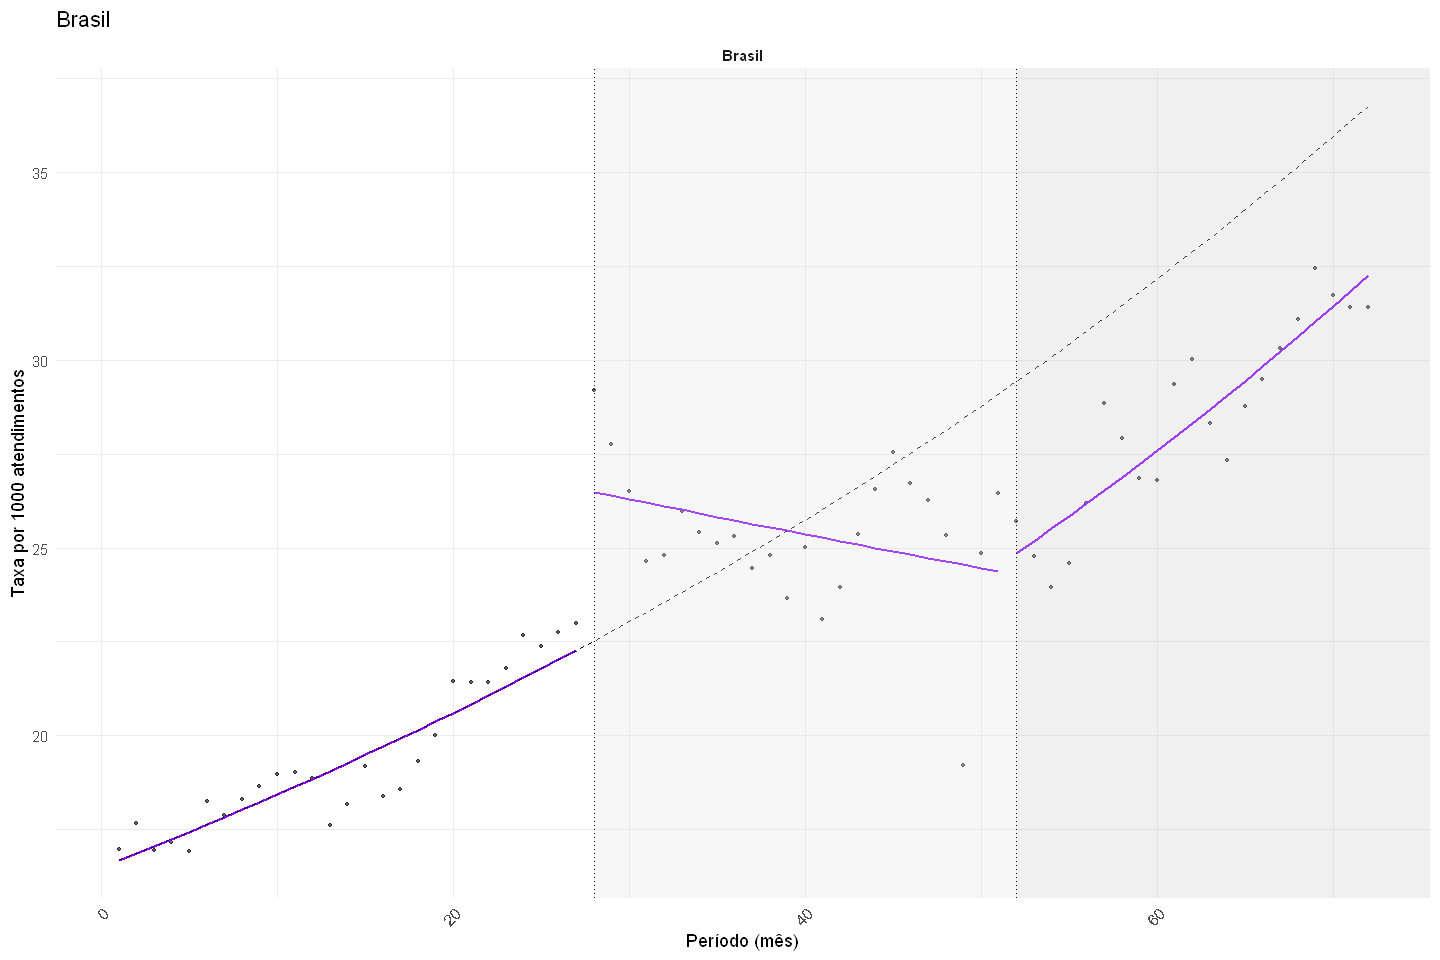

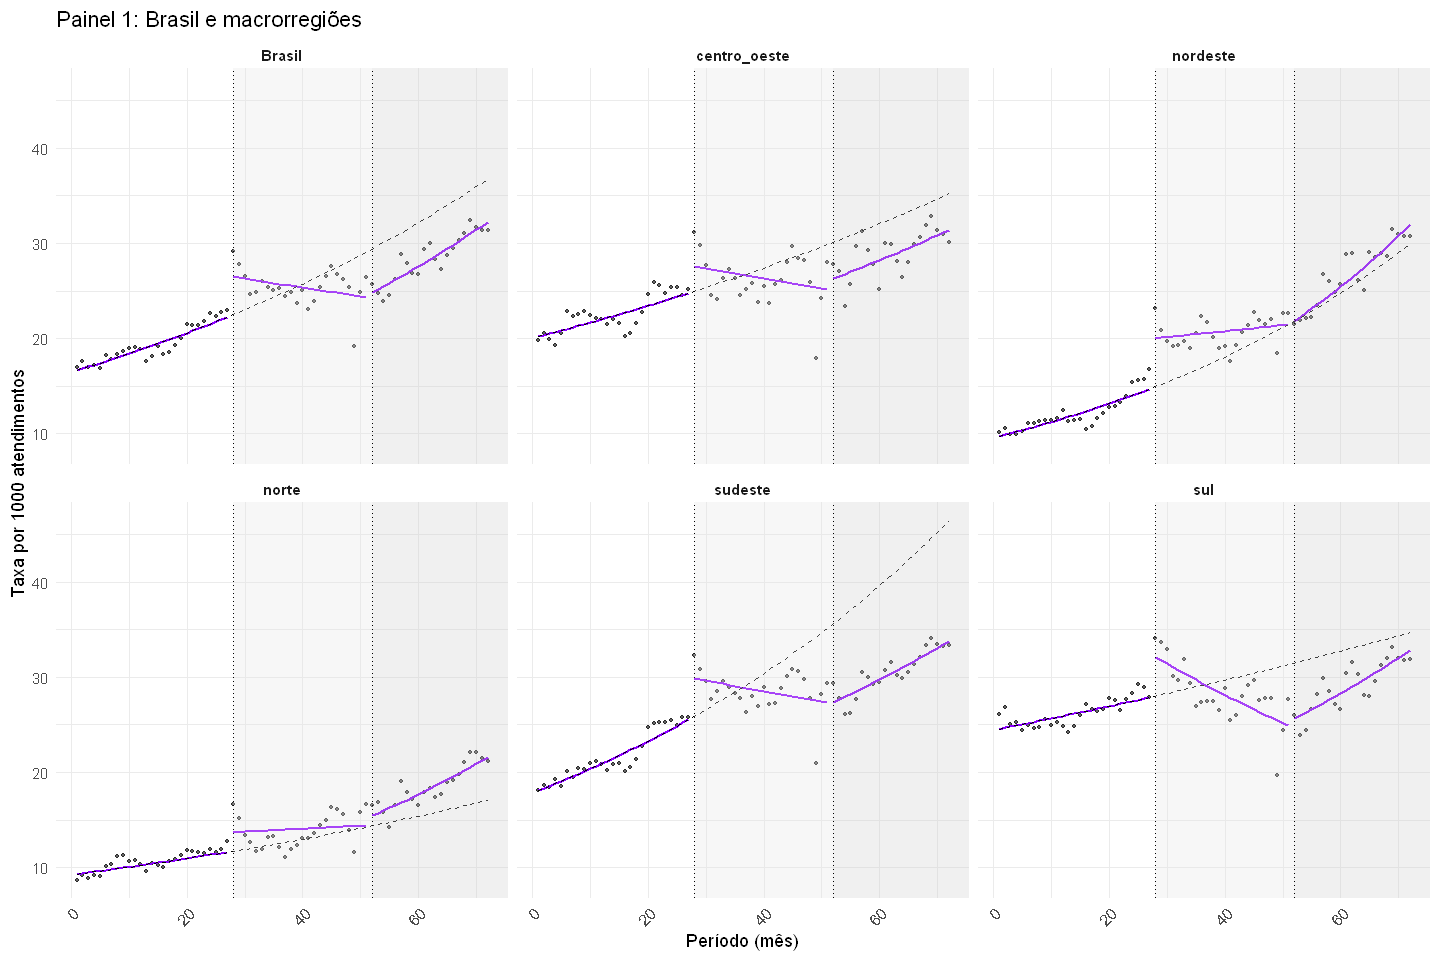

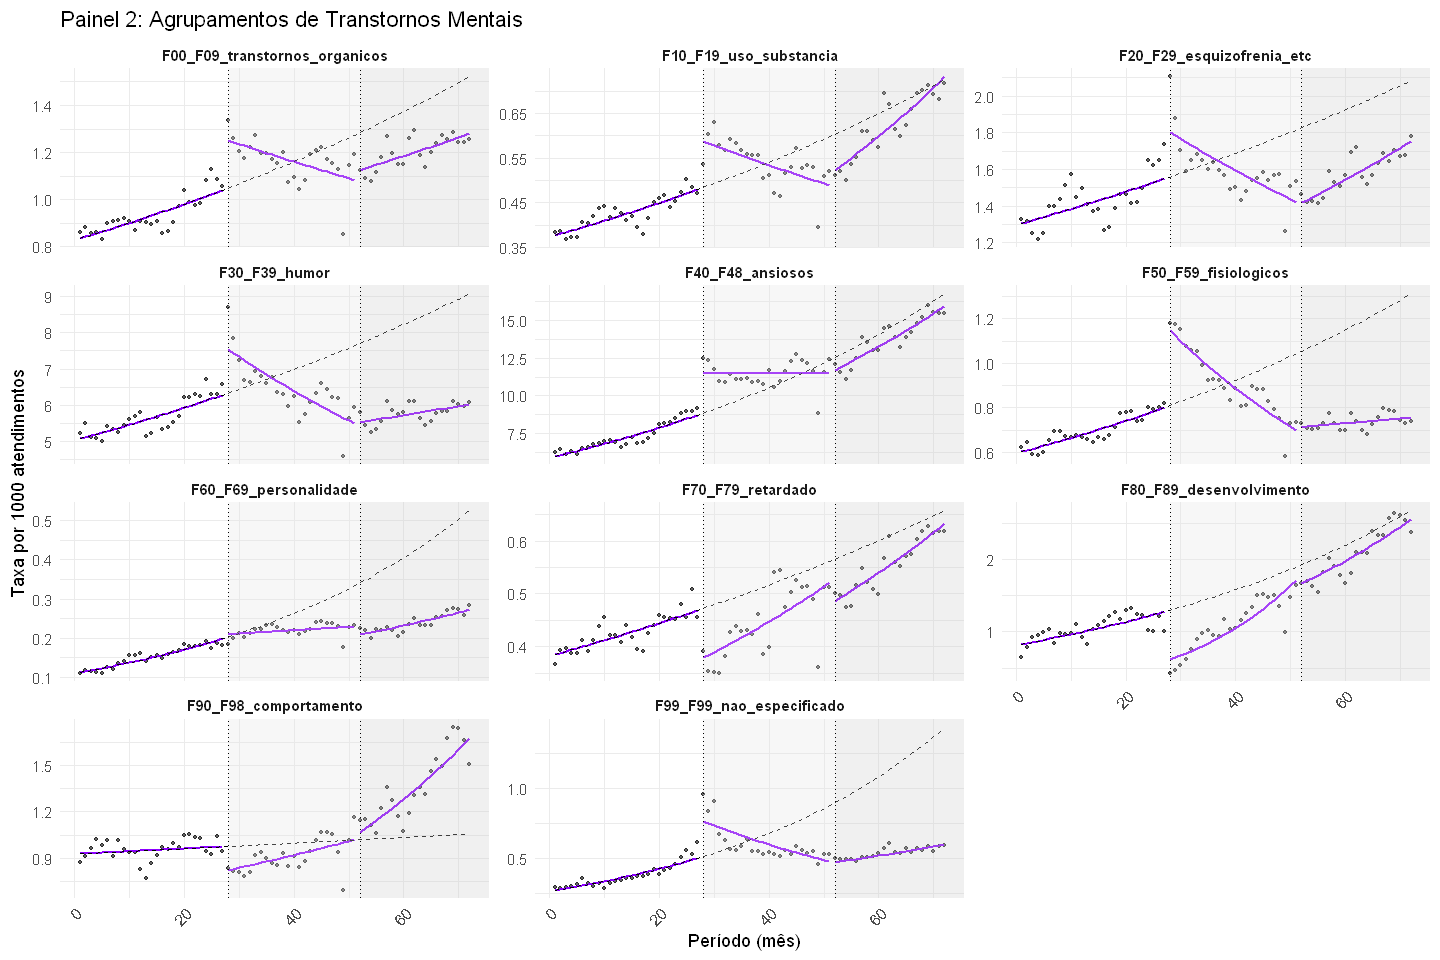

In [26]:
plot_its_painel(painel_brasil, titulo = "Brasil", ncol = 1)
plot_its_painel(painel_1, titulo = "Painel 1: Brasil e macrorregiões", ncol = 3, scales = "fixed")

plot_its_painel(painel_2, titulo = "Painel 2: Agrupamentos de Transtornos Mentais", ncol = 3)
# plot_its_painel(painel_neuroticos, titulo = "Humor e Ansiedade", scales = "fixed")
